In [1]:
! pip install vitaldb

  Obtaining dependency information for vitaldb from https://files.pythonhosted.org/packages/cc/09/94716247b2359cbbc2e10dba78d740eb79f423952f7da83a9c71593951fc/vitaldb-1.5.8-py3-none-any.whl.metadata
  Obtaining dependency information for wfdb from https://files.pythonhosted.org/packages/9c/b8/79fe1483255e728a791477d5ad748a8873063db854c77749a30d0e6d896c/wfdb-4.3.0-py3-none-any.whl.metadata
  Obtaining dependency information for aiohttp>=3.10.11 from https://files.pythonhosted.org/packages/e1/db/5d65af7cbe5f302e23b1ea5cfc156cd0c7738a0d2db531a3837d2754de94/aiohttp-3.13.0-cp310-cp310-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for fsspec>=2023.10.0 from https://files.pythonhosted.org/packages/47/71/70db47e4f6ce3e5c37a607355f80da8860a33226be640226ac52cb05ef2e/fsspec-2025.9.0-py3-none-any.whl.metadata
  Obtaining dependency information for matplotlib>=3.2.2 from https://files.pythonhosted.org/packages/45/a8/bfed45339160102bce21a44e38a358a1134a5f84c26166de03fb4a53208f/ma

In [2]:
import pandas as pd
data = pd.read_csv('251008_220007.csv')

In [2]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import vitaldb

# ----------------- config -----------------
FS = 100                      # Hz
ECG_CH = 'ECG_II'             # fixed to ECG II
ABP_CANDIDATES = ['ART', 'ABP', 'ART1', 'ART2', 'IBP']  # invasive arterial line
SPO2_CANDIDATES = ['SPO2', 'SpO2', 'SPO2_NELLCOR', 'SPO2_MASIMO']
ETCO2_CANDIDATES = ['ETCO2', 'ETCO2_MMHG', 'ETCO2_VAL', 'ETCO2_VALUE', 'ETCO2_NUM']

WIN_PRE, WIN_POST = 0.30, 0.60   # seconds around R
RR_MIN, RR_MAX = 0.35, 1.8       # allowed RR (s)
# relaxed physiologic ranges
SBP_MIN, SBP_MAX = 50, 280
DBP_MIN, DBP_MAX = 25, 180
MAP_MIN, MAP_MAX = 35, 200
# ------------------------------------------

def bandpass(x, fs=FS, lo=0.5, hi=40, order=3):
    b,a = butter(order, [lo/(fs/2), hi/(fs/2)], btype='band')
    return filtfilt(b, a, x) if len(x) > (order*3) else x

def detect_r_peaks(ecg, fs=FS):
    x = np.diff(ecg, prepend=ecg[0])**2
    thr = x.mean() + 2.0*x.std()
    cand,_ = find_peaks(x, distance=int(0.25*fs))
    return cand[x[cand] > thr]

def targets_from_abp(abp, r_idx, fs=FS):
    """Return MAP per beat (and SBP/DBP internally to filter)."""
    maps = []
    for i in range(len(r_idx)-1):
        rr = (r_idx[i+1]-r_idx[i])/fs
        if not (RR_MIN <= rr <= RR_MAX):
            maps.append(np.nan); continue
        seg = abp[r_idx[i]:r_idx[i+1]]
        if len(seg) < int(0.30*fs) or not np.all(np.isfinite(seg)):
            maps.append(np.nan); continue
        sbp, dbp = float(np.max(seg)), float(np.min(seg))
        map_ = float(np.mean(seg))
        ok = (SBP_MIN<=sbp<=SBP_MAX) and (DBP_MIN<=dbp<=DBP_MAX) and (MAP_MIN<=map_<=MAP_MAX) and (sbp>dbp)
        maps.append(map_ if ok else np.nan)
    return np.array(maps, dtype=np.float32)  # MAP only

def ecg_windows_around_r(ecg, r_idx, fs=FS, pre=WIN_PRE, post=WIN_POST):
    n_pre, n_post = int(pre*fs), int(post*fs)
    X = []
    for i in range(len(r_idx)-1):
        s = r_idx[i]-n_pre; e = r_idx[i]+n_post
        if s < 0 or e > len(ecg):
            X.append(None); continue
        w = ecg[s:e]
        X.append(w.astype(np.float32) if np.all(np.isfinite(w)) else None)
    return X

def first_present(values_2d, col_names, candidate_list):
    """Return (col_index, name) of first candidate with finite data; else (None, None)."""
    for name in candidate_list:
        if name in col_names:
            j = col_names.index(name)
            col = values_2d[:, j]
            if np.isfinite(col).sum() > FS*5:  # has some usable data
                return j, name
    return None, None

def process_one_case_three_vitals(caseid):
    # Try load ECG + all candidate channels; we'll pick present ones after
    chans_try = [ECG_CH] + ABP_CANDIDATES + SPO2_CANDIDATES + ETCO2_CANDIDATES
    vals = vitaldb.load_case(caseid, chans_try, 1/FS)
    if vals is None or vals.shape[0] < FS*10:
        print(f"[skip {caseid}] insufficient data"); return None

    names = chans_try[:]  # same order
    ecg = bandpass(np.nan_to_num(vals[:, 0], nan=0.0), fs=FS)

    # Which ABP/SPO2/ETCO2 are actually present?
    off = 1
    abp_j, abp_name = first_present(vals[:, off:off+len(ABP_CANDIDATES)], names[off:off+len(ABP_CANDIDATES)], ABP_CANDIDATES)
    if abp_j is not None: abp_j += off
    off2 = 1 + len(ABP_CANDIDATES)
    spo2_j, spo2_name = first_present(vals[:, off2:off2+len(SPO2_CANDIDATES)], names[off2:off2+len(SPO2_CANDIDATES)], SPO2_CANDIDATES)
    if spo2_j is not None: spo2_j += off2
    off3 = off2 + len(SPO2_CANDIDATES)
    etco2_j, etco2_name = first_present(vals[:, off3:off3+len(ETCO2_CANDIDATES)], names[off3:off3+len(ETCO2_CANDIDATES)], ETCO2_CANDIDATES)
    if etco2_j is not None: etco2_j += off3

    if spo2_j is None and etco2_j is None and abp_j is None:
        print(f"[skip {caseid}] none of MAP/SPO2/ETCO2 available"); return None

    # R-peaks
    ridx = detect_r_peaks(ecg, FS)
    if len(ridx) < 3:
        print(f"[skip {caseid}] too few R-peaks"); return None

    # Build X (ECG windows per beat)
    X_list = ecg_windows_around_r(ecg, ridx, FS)

    # Build Y columns: MAP (if ABP present), SPO2 at R, ETCO2 at R
    n_beats = len(X_list)
    Y_cols = []
    y_names = []

    if abp_j is not None:
        map_per_beat = targets_from_abp(vals[:, abp_j], ridx, FS)   # shape [n_beats]
        Y_cols.append(map_per_beat.reshape(-1,1)); y_names.append('MAP')

    r_for_beats = ridx[:-1]  # align with beats
    def sample_col(j):
        col = vals[:, j]
        col = np.nan_to_num(col, nan=np.nan)  # keep NaN if missing at instant
        return col[r_for_beats].astype(np.float32)

    if spo2_j is not None:
        Y_cols.append(sample_col(spo2_j).reshape(-1,1)); y_names.append('SPO2')
    if etco2_j is not None:
        Y_cols.append(sample_col(etco2_j).reshape(-1,1)); y_names.append('ETCO2')

    Y_full = np.concatenate(Y_cols, axis=1)

    # keep beats with valid X AND at least one finite Y
    keep = [i for i,(xrow,yrow) in enumerate(zip(X_list, Y_full)) if (xrow is not None) and np.any(np.isfinite(yrow))]
    if not keep:
        print(f"[skip {caseid}] no valid beat pairs after filtering"); return None

    X = np.stack([X_list[i] for i in keep])
    Y = Y_full[keep]

    print(f"[ok {caseid}] X={X.shape}, Y={Y.shape}, Y_cols={y_names}")
    return {"caseid": caseid, "X": X, "Y": Y, "y_names": y_names, "beat_caseids": np.full(X.shape[0], caseid, dtype=int)}

def build_XY_three_vitals_for_caseids(caseids):
    Xs, Ys, beat_caseids_all = [], [], []
    y_union = ['MAP', 'SPO2', 'ETCO2']  # target order we want; missing ones filled with NaN
    for cid in list(dict.fromkeys([int(c) for c in caseids if c==c])):  # unique, keep order
        out = process_one_case_three_vitals(cid)
        if out is None:
            continue
        # align Y columns to y_union
        Y_al = np.full((out['Y'].shape[0], len(y_union)), np.nan, dtype=np.float32)
        for j, nm in enumerate(out['y_names']):
            jj = y_union.index(nm)
            Y_al[:, jj] = out['Y'][:, j]
        Xs.append(out['X']); Ys.append(Y_al); beat_caseids_all.append(out['beat_caseids'])
    if not Xs:
        raise RuntimeError("No valid data from the provided case IDs.")
    X = np.concatenate(Xs, axis=0)
    Y = np.concatenate(Ys, axis=0)
    beat_caseids = np.concatenate(beat_caseids_all, axis=0)
    print(f"\nBuilt (ECG II + three vitals) → X={X.shape}, Y={Y.shape} with columns {y_union}")
    return X, Y, y_union, beat_caseids

In [3]:
# if your metadata DataFrame is `data` with a 'caseid' column:
selected_ids = data['caseid'].astype(int).tolist()
X, Y, y_cols, beat_caseids = build_XY_three_vitals_for_caseids(selected_ids)

print("X:", X.shape)          # beats × samples (ECG II windows)
print("Y:", Y.shape)          # beats × 3 (MAP, SPO2, ETCO2 — NaN where unavailable)
print("Y columns:", y_cols)

[skip 3] no valid beat pairs after filtering
[skip 6] no valid beat pairs after filtering
[skip 9] no valid beat pairs after filtering
[skip 14] no valid beat pairs after filtering
[skip 23] no valid beat pairs after filtering
[ok 32] X=(2, 90), Y=(2, 3), Y_cols=['MAP', 'SPO2', 'ETCO2']
[skip 37] no valid beat pairs after filtering
[ok 48] X=(2, 90), Y=(2, 2), Y_cols=['SPO2', 'ETCO2']
[ok 59] X=(36, 90), Y=(36, 3), Y_cols=['MAP', 'SPO2', 'ETCO2']
[skip 78] no valid beat pairs after filtering
[skip 80] no valid beat pairs after filtering
[skip 82] no valid beat pairs after filtering
[skip 85] no valid beat pairs after filtering
[skip 106] no valid beat pairs after filtering
[skip 115] no valid beat pairs after filtering
[skip 165] no valid beat pairs after filtering
[skip 172] no valid beat pairs after filtering
[skip 201] no valid beat pairs after filtering
[ok 209] X=(17, 90), Y=(17, 2), Y_cols=['SPO2', 'ETCO2']
[ok 222] X=(108, 90), Y=(108, 3), Y_cols=['MAP', 'SPO2', 'ETCO2']
[skip 2

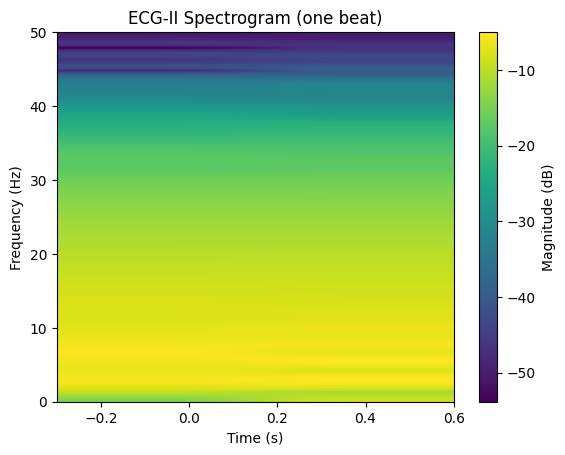

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

fs = 100.0                 # Hz (your X is 90 samples ≈ 0.9 s)
t0 = -0.30                 # seconds before R (for x-axis)
win = X.shape[1] / fs

# pick a random beat
i = np.random.randint(0, len(X))
x = (X[i] - X[i].mean()) / (X[i].std() + 1e-8)   # z-score

# spectrogram (ECG band ≤ ~40 Hz; use slightly larger nfft for smoother freq grid)
f, tt, Sxx = spectrogram(
    x, fs=fs, nperseg=64, noverlap=48, nfft=256, detrend=False, scaling='density', mode='magnitude'
)

# plot
plt.figure()
plt.imshow(
    10*np.log10(Sxx + 1e-12),  # dB
    aspect='auto', origin='lower',
    extent=[t0, t0 + win, f[0], f[-1]]
)
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time (s)'); plt.ylabel('Frequency (Hz)')
plt.title('ECG-II Spectrogram (one beat)')
plt.show()

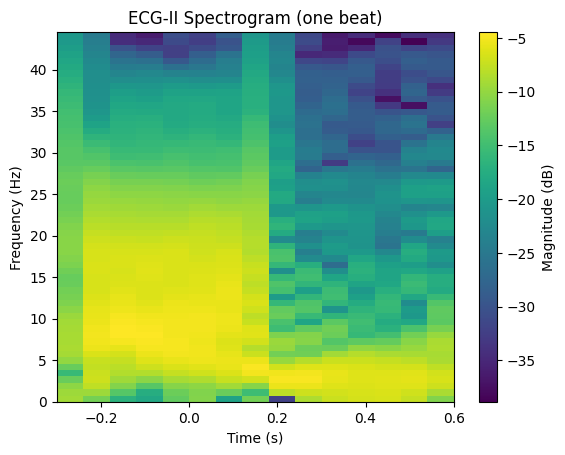

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

fs = 100.0        # Hz
t0 = -0.30        # seconds before R
eps = 1e-12

def show_beat_spectrogram(x, fs=100.0, nperseg=32, noverlap=28, nfft=128, fmax=45):
    # z-score per beat
    x = (x - x.mean()) / (x.std() + 1e-8)
    f, tt, Sxx = spectrogram(
        x, fs=fs, nperseg=nperseg, noverlap=noverlap,
        nfft=nfft, detrend=False, scaling='density', mode='magnitude'
    )
    # crop frequency axis
    imax = np.searchsorted(f, fmax)
    f, S = f[:imax], Sxx[:imax, :]

    plt.figure()
    # use nearest to avoid misleading smoothing
    plt.imshow(
        10*np.log10(S + eps), origin='lower', aspect='auto',
        extent=[t0, t0 + len(x)/fs, f[0], f[-1]], interpolation='nearest'
    )
    plt.colorbar(label='Magnitude (dB)')
    plt.xlabel('Time (s)'); plt.ylabel('Frequency (Hz)')
    plt.title('ECG-II Spectrogram (one beat)')
    plt.show()

# try a random beat
i = np.random.randint(len(X))
show_beat_spectrogram(X[i], fs=fs)

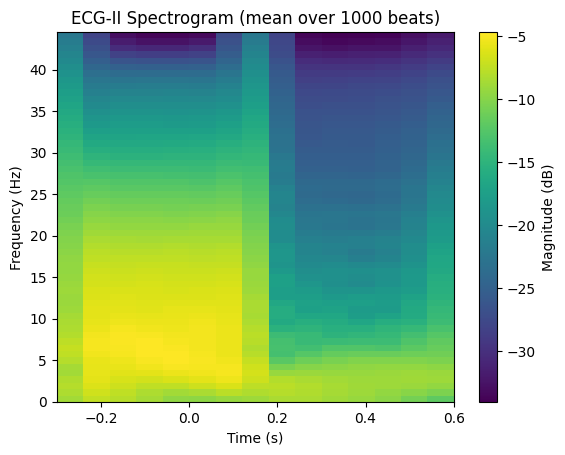

In [6]:
def mean_spectrogram(X, fs=100.0, nperseg=32, noverlap=28, nfft=128, fmax=45, N=1000, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(X), size=min(N, len(X)), replace=False)
    acc = None
    for j in idx:
        x = (X[j] - X[j].mean()) / (X[j].std() + 1e-8)
        f, tt, Sxx = spectrogram(x, fs=fs, nperseg=nperseg, noverlap=noverlap,
                                 nfft=nfft, detrend=False, scaling='density', mode='magnitude')
        if acc is None:
            acc = np.zeros_like(Sxx)
        acc += Sxx
    Smean = acc / len(idx)

    imax = np.searchsorted(f, fmax)
    f, S = f[:imax], Smean[:imax, :]

    plt.figure()
    plt.imshow(10*np.log10(S + 1e-12), origin='lower', aspect='auto',
               extent=[t0, t0 + X.shape[1]/fs, f[0], f[-1]], interpolation='nearest')
    plt.colorbar(label='Magnitude (dB)')
    plt.xlabel('Time (s)'); plt.ylabel('Frequency (Hz)')
    plt.title(f'ECG-II Spectrogram (mean over {len(idx)} beats)')
    plt.show()

mean_spectrogram(X, fs=fs)

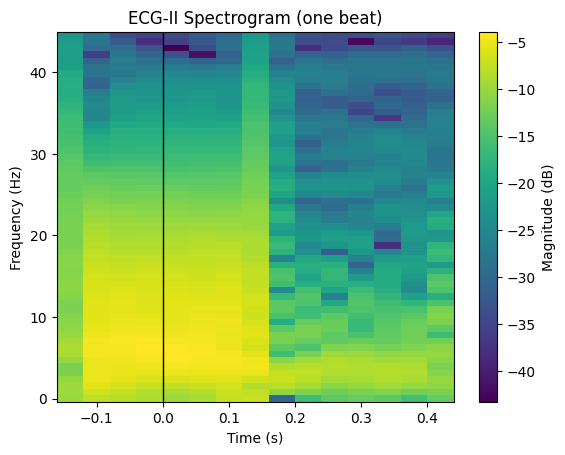

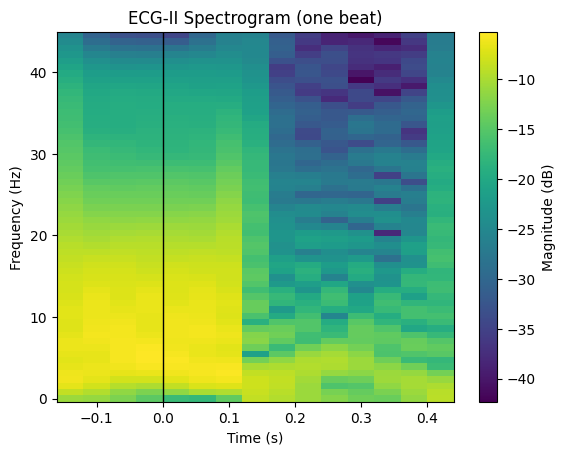

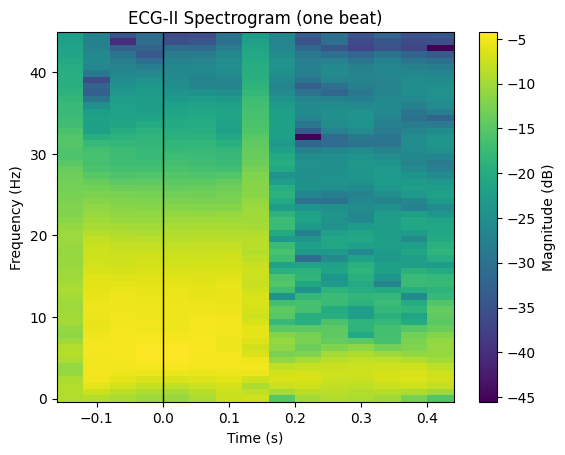

In [7]:
import numpy as np, matplotlib.pyplot as plt
from scipy.signal import spectrogram

fs = 100.0
pre = 0.30                 # your WIN_PRE (s)
eps = 1e-12

def show_beat_spectrogram(x, fs=100.0, pre=0.30, nperseg=32, noverlap=28, nfft=128, fmax=45):
    # z-score per beat (stabilize dynamic range)
    x = (x - x.mean()) / (x.std() + 1e-8)

    f, tt, Sxx = spectrogram(
        x, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft,
        detrend=False, scaling='density', mode='magnitude'
    )
    # tt are **segment centers** measured from start of the window (which begins at -pre)
    t = -pre + tt

    # crop to ECG band
    imax = np.searchsorted(f, fmax)
    f, Sxx = f[:imax], Sxx[:imax, :]

    plt.figure()
    # use pcolormesh with actual time bins; no interpolation “smearing”
    plt.pcolormesh(t, f, 10*np.log10(Sxx + eps), shading='nearest')
    plt.axvline(0.0, color='k', linewidth=1)  # expected R-peak center
    plt.xlabel('Time (s)'); plt.ylabel('Frequency (Hz)')
    plt.title('ECG-II Spectrogram (one beat)')
    cbar = plt.colorbar(); cbar.set_label('Magnitude (dB)')
    plt.show()

# try a few beats
for _ in range(3):
    i = np.random.randint(len(X))
    show_beat_spectrogram(X[i], fs=fs, pre=pre, nperseg=32, noverlap=28, nfft=128)

In [8]:
import numpy as np
from scipy.signal import stft, get_window

def make_stft_specs(
    X, fs=100.0, pre=0.30,
    nperseg=24, noverlap=20, nfft=128,
    window="hann",
    fmax=45.0,
    out="logmag",      # "logmag" | "mag" | "pow" | "logpow"
    norm="per_beat",   # None | "per_beat" | "global"
    center_time=True,  # shift time axis so 0 ~= R-peak (start at -pre)
    detrend=False,
    boundary=None,     # None to avoid padding artifacts on 0.9 s windows
    padded=False
):
    """
    X: np.ndarray [N, L] (e.g., L=90 samples at fs=100 Hz)
    Returns:
      S: [N, F, T] STFT spectrograms (log-magnitude by default)
      f: [F] frequency bins (Hz), cropped to <= fmax
      t: [T] time bins (s), centered so 0 ≈ R-peak if center_time=True
    """
    # Prepare window
    win = get_window(window, nperseg, fftbins=True)

    # Run once to determine shapes
    f, t, Z = stft(
        X[0], fs=fs, window=win, nperseg=nperseg, noverlap=noverlap, nfft=nfft,
        detrend=detrend, return_onesided=True, boundary=boundary, padded=padded
    )
    if center_time:
        t = t - pre  # your window starts at -pre s, so center 0 at R

    # Crop frequency band
    imax = np.searchsorted(f, fmax)
    f = f[:imax]

    # Allocate output
    N, F, T = len(X), imax, len(t)
    S = np.empty((N, F, T), dtype=np.float32)

    # Magnitude/power conversion helper
    def conv(Z):
        if out == "mag":
            return np.abs(Z)
        if out == "pow":
            return (np.abs(Z)**2)
        if out == "logpow":
            return 10.0*np.log10((np.abs(Z)**2) + 1e-12)
        # default: log-magnitude
        return 20.0*np.log10(np.abs(Z) + 1e-12)

    # Process all beats
    for i in range(N):
        # stabilize per-beat before STFT (helps across subjects)
        x = (X[i] - X[i].mean()) / (X[i].std() + 1e-8)
        _, _, Zi = stft(
            x, fs=fs, window=win, nperseg=nperseg, noverlap=noverlap, nfft=nfft,
            detrend=detrend, return_onesided=True, boundary=boundary, padded=padded
        )
        Si = conv(Zi)[:imax, :]   # F x T
        S[i] = Si.astype(np.float32)

    # Optional normalization
    if norm == "per_beat":
        m = S.mean(axis=(1,2), keepdims=True)
        s = S.std (axis=(1,2), keepdims=True) + 1e-8
        S = (S - m) / s
    elif norm == "global":
        m = S.mean(); s = S.std() + 1e-8
        S = (S - m) / s

    return S, f, t

In [9]:
S, f, t = make_stft_specs(X, fs=100.0, pre=0.30,
                          nperseg=24, noverlap=20, nfft=128,
                          window="hann", fmax=45.0,
                          out="logmag", norm="per_beat",
                          boundary=None, padded=False)

print("STFT spectrograms:", S.shape)   # e.g., (103188, F, T)

STFT spectrograms: (103188, 58, 17)


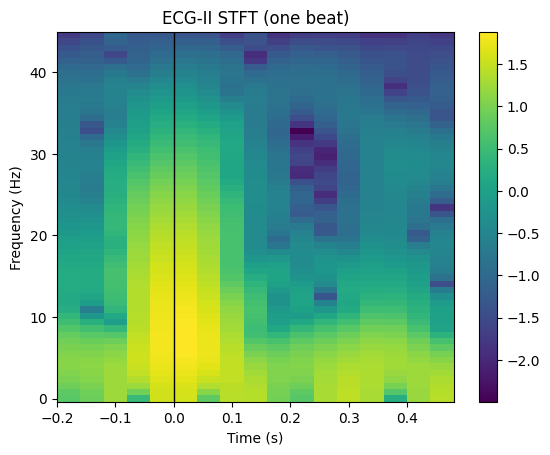

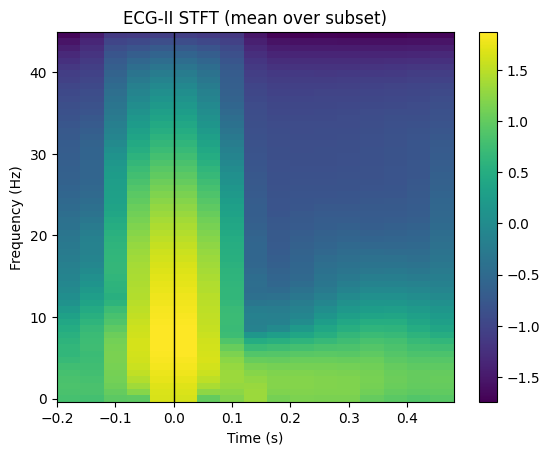

In [10]:
# Visualize one beat and a mean map
import matplotlib.pyplot as plt
i = np.random.randint(len(S))
plt.figure(); plt.pcolormesh(t, f, S[i], shading="nearest"); plt.axvline(0, color="k", lw=1)
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)"); plt.title("ECG-II STFT (one beat)"); plt.colorbar(); plt.show()

idx = np.random.default_rng(0).choice(len(S), size=min(2000, len(S)), replace=False)
Smean = S[idx].mean(axis=0)
plt.figure(); plt.pcolormesh(t, f, Smean, shading="nearest"); plt.axvline(0, color="k", lw=1)
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)"); plt.title("ECG-II STFT (mean over subset)"); plt.colorbar(); plt.show()

In [11]:
# --- assumes you already have these in memory ---
# S: np.ndarray, shape (N, F, T)  # STFT (log-magnitude, normalized per beat)
# Y: np.ndarray, shape (N, 3)     # columns e.g. ['MAP', 'SPO2', 'ETCO2'] with NaNs where missing
# f: np.ndarray, shape (F,)       # frequency axis (Hz)
# t: np.ndarray, shape (T,)       # time axis (s), centered (0 ~ R-peak)
# y_cols: list[str]               # e.g. ['MAP','SPO2','ETCO2']
# beat_caseids: np.ndarray, shape (N,)  # optional; for group (patient) split

save_path = "vitaldb_ecgii_stft.npz"
np.savez_compressed(
    save_path,
    S=S.astype(np.float32),
    Y=Y.astype(np.float32),
    f=f.astype(np.float32),
    t=t.astype(np.float32),
    y_cols=np.array(y_cols, dtype=object),
    beat_caseids=beat_caseids.astype(np.int32) if 'beat_caseids' in globals() else np.array([], dtype=np.int32)
)
print(f"Saved -> {save_path}")

Saved -> vitaldb_ecgii_stft.npz


In [6]:
import numpy as np
# Loading Code
loaded = np.load("vitaldb_ecgii_stft.npz", allow_pickle=True)
S = loaded["S"]          # (N,F,T)
Y = loaded["Y"]          # (N,3)
f = loaded["f"]          # (F,)
t = loaded["t"]          # (T,)
y_cols = list(loaded["y_cols"])
beat_caseids = loaded["beat_caseids"]
if beat_caseids.size == 0:
    beat_caseids = None
print(S.shape, Y.shape, y_cols)

(103188, 58, 17) (103188, 3) ['MAP', 'SPO2', 'ETCO2']


In [3]:
! pip install tensorflow scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 265.4 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 2.4 MB/s eta 0:00:00:00:01
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 21.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [10]:
# (macOS / venv / pip)
! python -m pip install --upgrade "protobuf==3.20.3"
# if you still see the error, try the broader pin:
! python -m pip install --upgrade "protobuf<5.0.0"

  Obtaining dependency information for protobuf==3.20.3 from https://files.pythonhosted.org/packages/8d/14/619e24a4c70df2901e1f4dbc50a6291eb63a759172558df326347dce1f0d/protobuf-3.20.3-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.32.1
    Uninstalling protobuf-6.32.1:
      Successfully uninstalled protobuf-6.32.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.20.0 requires protobuf>=5.28.0, but you have protobuf 3.20.3 which is incompatible.
  Obtaining dependency information for protobuf<5.0.0 from https://files.pythonhosted.org/packages/28/d7/ab27049a035b258dab43445eb6ec84a26277b16105b277cbe0a7698bdc6c/protobuf-4.25.8-cp37-abi3-macosx_10_9_universal2.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import tensorflow as tf

In [7]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GroupKFold, train_test_split

# ---------- prepare tensors ----------
N, F, T = S.shape
X = S[..., None]  # channels_last -> (N, F, T, 1)

# split (grouped by case if available)
idx = np.arange(N)
if beat_caseids is not None:
    gkf = GroupKFold(n_splits=5)
    tr_idx, te_idx = next(gkf.split(idx, groups=beat_caseids))
    gkf2 = GroupKFold(n_splits=5)
    tr_core, va_idx = next(gkf2.split(tr_idx, groups=beat_caseids[tr_idx]))
    tr_idx = tr_idx[tr_core]
else:
    tr_idx, te_idx = train_test_split(idx, test_size=0.2, random_state=42)
    tr_idx, va_idx = train_test_split(tr_idx, test_size=0.2, random_state=42)

X_tr, X_va, X_te = X[tr_idx], X[va_idx], X[te_idx]
Y_tr, Y_va, Y_te = Y[tr_idx], Y[va_idx], Y[te_idx]

# per-target normalization on training set (ignore NaNs)
y_mean = np.nanmean(Y_tr, axis=0)
y_std  = np.nanstd (Y_tr, axis=0) + 1e-8
def norm_y(a):  return (a - y_mean) / y_std
def denorm_y(a): return a * y_std + y_mean

Y_tr_n = norm_y(Y_tr); Y_va_n = norm_y(Y_va); Y_te_n = norm_y(Y_te)

# ---------- tf.data datasets ----------
def make_ds(X, Y, bs=256, shuffle=False):
    # Keep NaNs in Y; our loss will mask them.
    ds = tf.data.Dataset.from_tensor_slices((X.astype(np.float32), Y.astype(np.float32)))
    if shuffle:
        ds = ds.shuffle(min(len(X), 10000), seed=42)
    ds = ds.batch(bs).prefetch(tf.data.AUTOTUNE)
    return ds

ds_tr = make_ds(X_tr, Y_tr_n, shuffle=True)
ds_va = make_ds(X_va, Y_va_n)
ds_te = make_ds(X_te, Y_te_n)

In [8]:
X_tr.shape

(66944, 58, 17, 1)

In [9]:
# ---------- masked MAE loss ----------
@tf.function
def masked_mae(y_true, y_pred):
    # mask: True where finite labels exist
    mask = tf.math.is_finite(y_true)
    y_true_clean = tf.where(mask, y_true, 0.0)
    abs_err = tf.abs(y_pred - y_true_clean) * tf.cast(mask, tf.float32)
    denom = tf.reduce_sum(tf.cast(mask, tf.float32)) + 1e-6
    return tf.reduce_sum(abs_err) / denom

# optional per-target masked MAE metric (reports in z-units)
def make_masked_mae_k(k):
    @tf.function
    def m(y_true, y_pred):
        yt = y_true[..., k:k+1]; yp = y_pred[..., k:k+1]
        mask = tf.math.is_finite(yt)
        yt = tf.where(mask, yt, 0.0)
        err = tf.abs(yp - yt) * tf.cast(mask, tf.float32)
        denom = tf.reduce_sum(tf.cast(mask, tf.float32)) + 1e-6
        return tf.reduce_sum(err) / denom
    return m

In [10]:
# ---------- model ----------
from tensorflow.keras import layers, models

inputs = layers.Input(shape=(F, T, 1))
x = layers.Conv2D(16, (3,3), padding="same", activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(96, (3,3), padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(3)(x)  # 3 targets (z-normalized)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-3, weight_decay=1e-4),
    loss=masked_mae,
    metrics=[make_masked_mae_k(0), make_masked_mae_k(1), make_masked_mae_k(2)]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 58, 17, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 58, 17, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 58, 17, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 17, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 8, 96)      │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,411 (333.64 KB)

 Trainable params: 85,251 (333.01 KB)

 Non-trainable params: 160 (640.00 B)

In [11]:
# ---------- train ----------
ckpt = tf.keras.callbacks.ModelCheckpoint("best_spec_cnn.keras", monitor="val_loss",
                                        save_best_only=True, mode="min", verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
hist = model.fit(ds_tr, validation_data=ds_va, epochs=25, callbacks=[ckpt, es])

Epoch 1/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.6225 - m: 0.6264 - m_1: 0.2493 - m_2: 0.2531
Epoch 1: val_loss improved from None to 0.64702, saving model to best_spec_cnn.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 44s 161ms/step - loss: 0.5923 - m: 0.5960 - m_1: 0.3456 - m_2: 0.3106 - val_loss: 0.6470 - val_m: 0.6761 - val_m_1: 0.0856 - val_m_2: 0.3051
Epoch 2/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.5416 - m: 0.5439 - m_1: 0.3053 - m_2: 0.1718
Epoch 2: val_loss improved from 0.64702 to 0.64178, saving model to best_spec_cnn.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 53s 204ms/step - loss: 0.5378 - m: 0.5411 - m_1: 0.3057 - m_2: 0.2609 - val_loss: 0.6418 - val_m: 0.6712 - val_m_1: 0.0984 - val_m_2: 0.1068
Epoch 3/25
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.5170 - m: 0.5195 - m_1: 0.2663 - m_2: 0.1833
Epoch 3: val_loss improved from 0.64178 to 0.53648, saving model to best_spec_cnn.keras
262/262 ━━━━━━━━━━━━━━━━━━━━ 79s 300ms/step - loss: 0.5201 - m: 0.5232 -

In [12]:
# y_std must be from the TRAIN set
print({
  "MAP_mmHg":  0.5265 * y_std[0],
  "SpO2_pct":  0.0988 * y_std[1],
  "ETCO2_mmHg":0.1009 * y_std[2],
})

{'MAP_mmHg': np.float32(7.768976), 'SpO2_pct': np.float32(0.17280129), 'ETCO2_mmHg': np.float32(0.84732443)}


In [13]:
import tensorflow as tf

# reuse your custom loss/metrics only if needed; compile=False avoids needing them
best = tf.keras.models.load_model("best_spec_cnn.keras", compile=False)
best.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 58, 17, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 58, 17, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 58, 17, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 17, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 8, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 8, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 8, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 8, 96)      │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,411 (333.64 KB)

 Trainable params: 85,251 (333.01 KB)

 Non-trainable params: 160 (640.00 B)

In [14]:
best.save('vital_recognition_model.keras')